# Assignment 4 - Autoencoders and Variational Autoencoders

### Importing necessary packages

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

### Downloading MNIST Dataset

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data',  train=False,download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,   batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3300598.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 43939.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 329634.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1037215.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Q1 (a) Calculating train and test reconstruction errors for the two models

#### Autoencoder model

In [3]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 192),
            nn.ReLU(),
            nn.Linear(192, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 192),
            nn.ReLU(),
            nn.Linear(192, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### Training Function

In [4]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=20):
    model.to(device)  # Move model to the appropriate device
    model.train()
    for epoch in range(num_epochs):
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Flatten the inputs and outputs for calculating MSE loss
            inputs_flat = inputs.view(inputs.size(0), -1)
            outputs_flat = outputs.view(outputs.size(0), -1)
            
            loss = criterion(outputs_flat, inputs_flat)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch == 0:
            print("-------------------------------------------------")
            
        print(f"|\t Epoch {epoch+1} \t | \tLoss = {loss.item():.4f} \t|")
        print("-------------------------------------------------")

#### Evaluating the model

In [5]:
# Evaluate function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Flatten the inputs and outputs for calculating MSE loss
            inputs_flat = inputs.view(inputs.size(0), -1)
            outputs_flat = outputs.view(outputs.size(0), -1)
            
            total_loss += criterion(outputs_flat, inputs_flat).item() * inputs.size(0)
    
    return total_loss / len(dataloader.dataset)

#### Putting it all together

In [6]:
# Initialize models
latent_dims = [32, 64]
models = []
for latent_dim in latent_dims:
    model = Autoencoder(latent_dim).to(device)
    models.append(model)

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizers = [optim.Adam(model.parameters(), lr=1e-3) for model in models]

# Train models
i = 0
for model, optimizer in zip(models, optimizers):
    print(f'\n Training Autoencoder with latent dimension {latent_dims[i]} \n')
    train_model(model, criterion, optimizer)
    i += 1

# Evaluate models
train_losses = []
test_losses = []
for model in models:
    train_loss = evaluate_model(model, train_loader)
    test_loss = evaluate_model(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Report reconstruction errors
for i, latent_dim in enumerate(latent_dims):
    print('\n')
    print(f'Autoencoder with latent dimension {latent_dim}:')
    print(f'Train Reconstruction Error: {train_losses[i]:.4f}')
    print(f'Test Reconstruction Error: {test_losses[i]:.4f}')
    print()


 Training Autoencoder with latent dimension 32 

-------------------------------------------------
|	 Epoch 1 	 | 	Loss = 0.0219 	|
-------------------------------------------------
|	 Epoch 2 	 | 	Loss = 0.0186 	|
-------------------------------------------------
|	 Epoch 3 	 | 	Loss = 0.0201 	|
-------------------------------------------------
|	 Epoch 4 	 | 	Loss = 0.0165 	|
-------------------------------------------------
|	 Epoch 5 	 | 	Loss = 0.0149 	|
-------------------------------------------------
|	 Epoch 6 	 | 	Loss = 0.0138 	|
-------------------------------------------------
|	 Epoch 7 	 | 	Loss = 0.0149 	|
-------------------------------------------------
|	 Epoch 8 	 | 	Loss = 0.0143 	|
-------------------------------------------------
|	 Epoch 9 	 | 	Loss = 0.0126 	|
-------------------------------------------------
|	 Epoch 10 	 | 	Loss = 0.0111 	|
-------------------------------------------------
|	 Epoch 11 	 | 	Loss = 0.0128 	|
-----------------------------------

#### Visualizing the reconstructed images

Visualizing reconstructions for training data


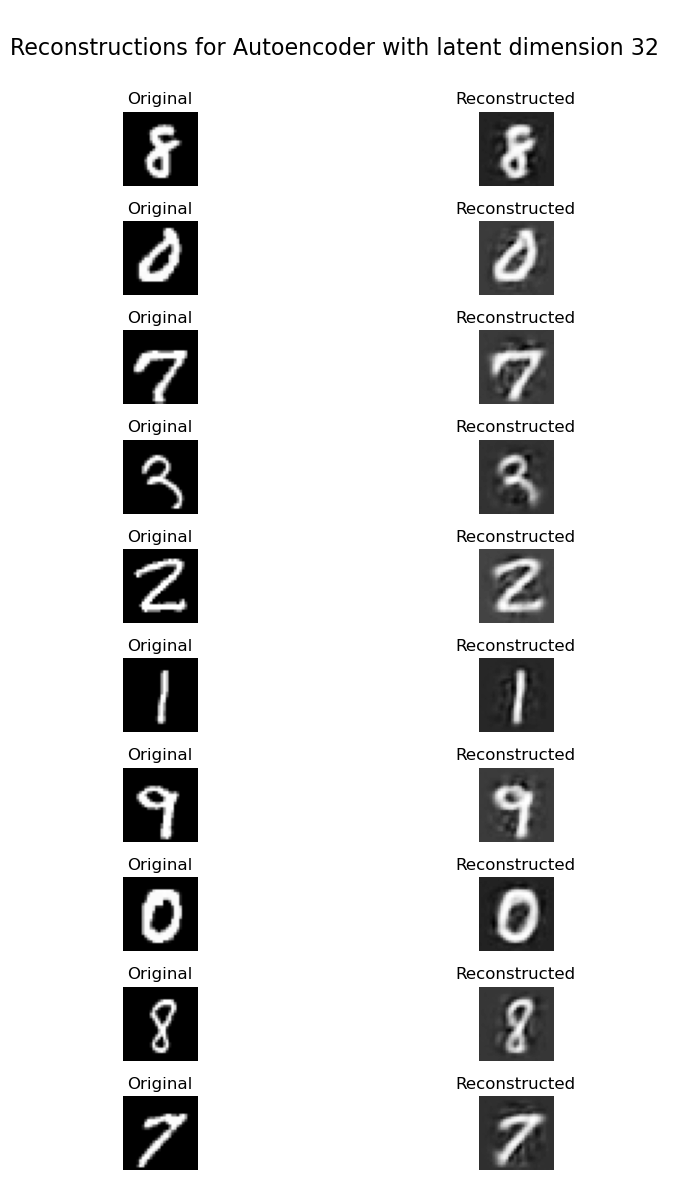

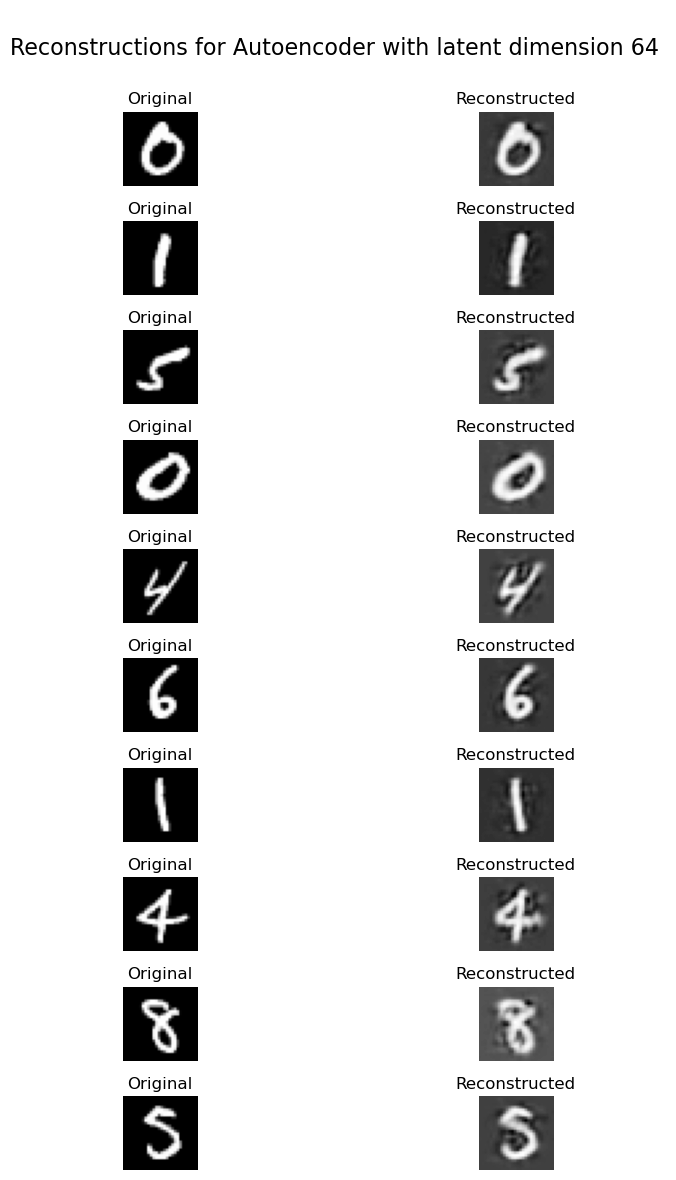



-----------------------------------------------------------------------------------------------------------

Visualizing reconstructions for test data:



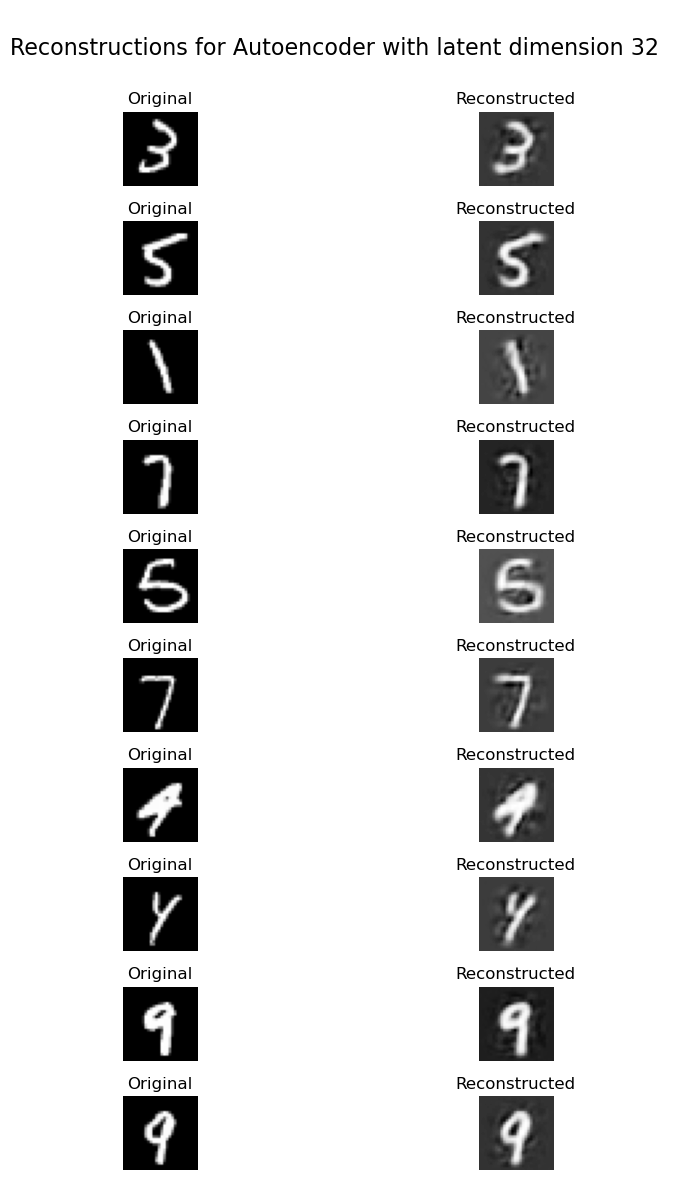

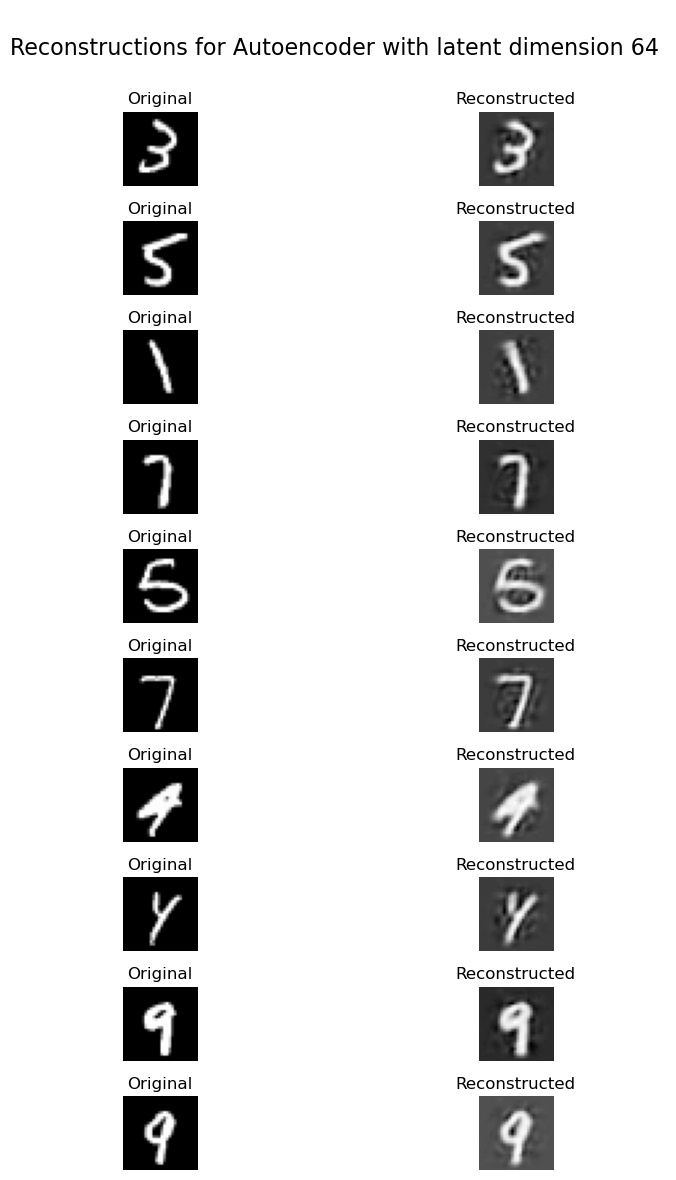

In [7]:
def visualize_reconstructions(model, dataloader, latent_dim, num_samples=10):
    model.eval()
    with torch.no_grad():
        plt.figure(figsize=(10, 12))
        plt.suptitle(f'\nReconstructions for Autoencoder with latent dimension {latent_dim} \n', fontsize=16)
        for i, data in enumerate(dataloader):
            if i >= num_samples:
                break
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            for j in range(inputs.size(0)):
                input_image = inputs[j].cpu().numpy().squeeze()
                output_image = outputs[j].cpu().numpy().reshape(28, 28)
                plt.subplot(num_samples, 2, 2*i+1)
                plt.imshow(input_image, cmap='gray')
                plt.title('Original')
                plt.axis('off')
                plt.subplot(num_samples, 2, 2*i+2)
                plt.imshow(output_image, cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        
print('Visualizing reconstructions for training data')
for model, latent_dim in zip(models, latent_dims):
    visualize_reconstructions(model, train_loader, latent_dim)
    print('\n')

print('-'*107)
print('\nVisualizing reconstructions for test data:\n')
for model, latent_dim in zip(models, latent_dims):
    visualize_reconstructions(model, test_loader, latent_dim)

### Q1 (b) Performing the reconstruction on the line joining two training data samples in the hidden space.

#### Interpolating between two points in the latent space

In [8]:
# Function to interpolate between two points in the latent space
def interpolate_latent_points(latent_point1, latent_point2, num_steps=10):
    steps = np.linspace(0, 1, num_steps)
    interpolated_points = []
    for step in steps:
        interpolated_point = latent_point1 * (1 - step) + latent_point2 * step
        interpolated_points.append(interpolated_point.cpu().numpy())
    return np.array(interpolated_points)

#### Performing reconstruction along the interpolated latent points

In [9]:
# Function to perform reconstruction along the interpolated latent points
def reconstruction_along_line(model, latent_dim, data_loader, num_pairs=5, num_steps=10):
    model.eval()
    with torch.no_grad():
        for i in range(num_pairs):
            # Select two random samples
            idx1, idx2 = np.random.choice(len(data_loader.dataset), 2, replace=False)
            input1, _ = data_loader.dataset[idx1]
            input2, _ = data_loader.dataset[idx2]
            input1 = input1.to(device).unsqueeze(0)
            input2 = input2.to(device).unsqueeze(0)

            # Encode the samples to obtain latent representations
            latent1 = model.encoder(input1.view(-1, 28*28))
            latent2 = model.encoder(input2.view(-1, 28*28))

            # Interpolate between the latent representations
            interpolated_latent_points = interpolate_latent_points(latent1, latent2, num_steps=num_steps)

            # Decode the interpolated latent representations to obtain reconstructed images
            reconstructed_images = []
            for latent_point in interpolated_latent_points:
                latent_point = torch.tensor(latent_point).to(device)
                output = model.decoder(latent_point)
                reconstructed_images.append(output.view(28, 28).cpu().numpy())

            # Plot the reconstructed images along the line
            plt.figure(figsize=(15, 3))
            for j, image in enumerate(reconstructed_images):
                plt.subplot(1, num_steps, j+1)
                plt.imshow(image, cmap='gray')
                plt.title(f'Step {j+1}')
                plt.axis('off')
            plt.suptitle(f'\n Reconstruction Along Line: Pair {i+1} (Latent Dimension {latent_dim})', fontsize=16)
            plt.show()

#### Plotting the graphs of Original and Reconstructed Images

Performing reconstruction along the line in the hidden space: 



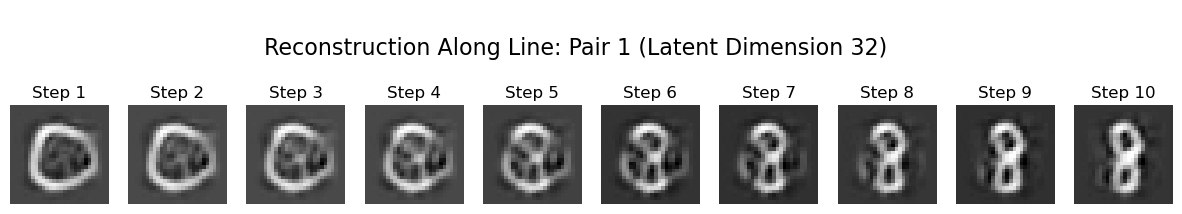

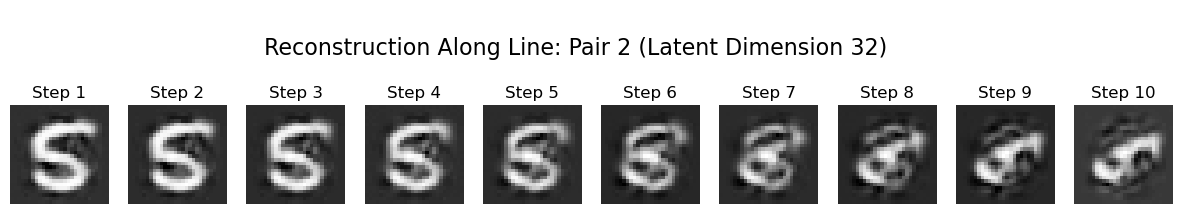

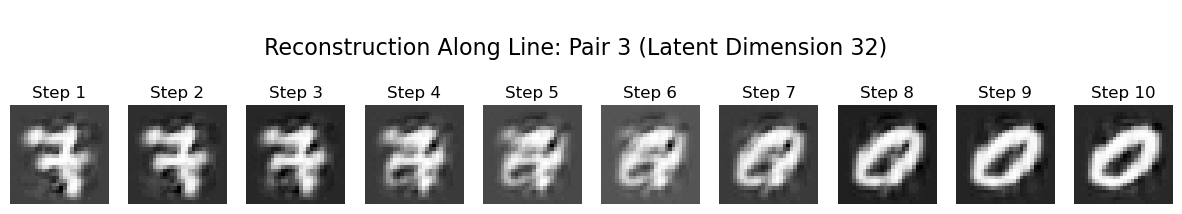

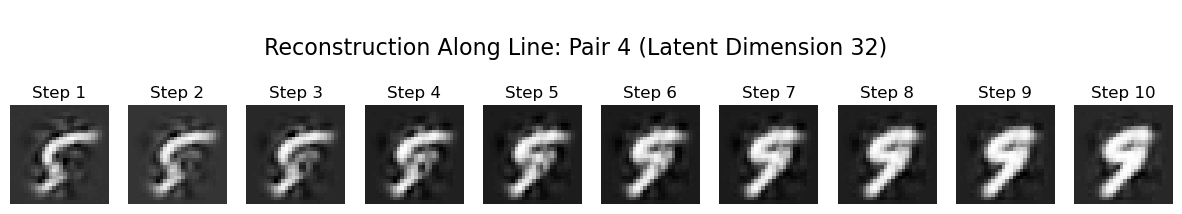

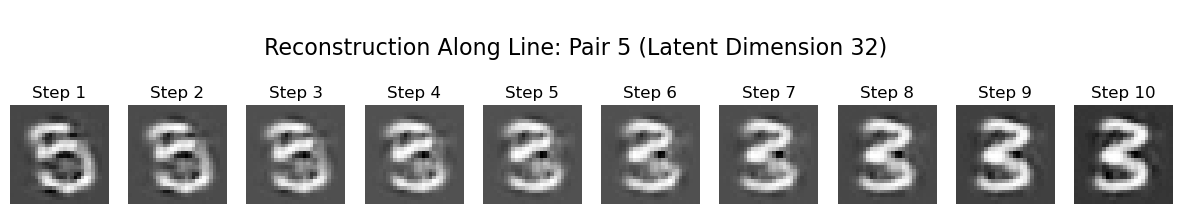

-----------------------------------------------------------------------------------------------------------


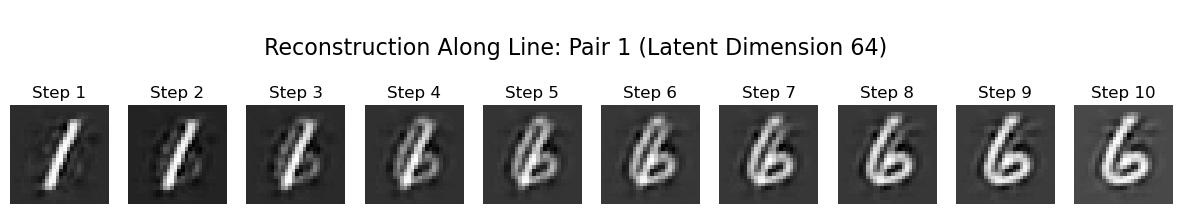

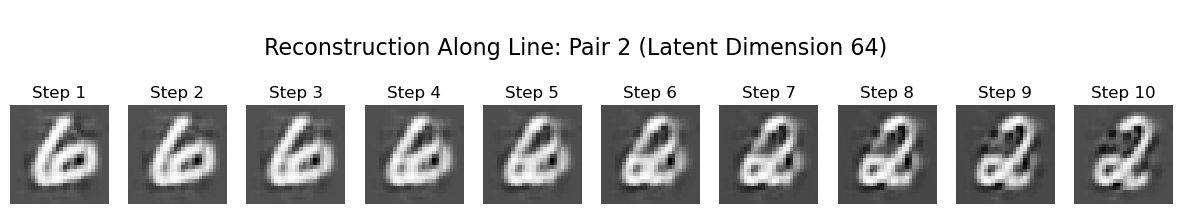

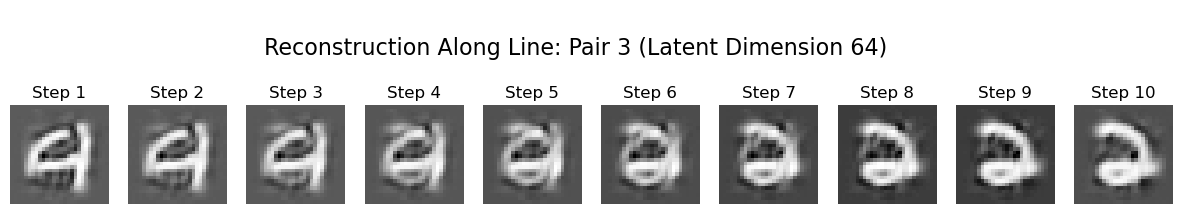

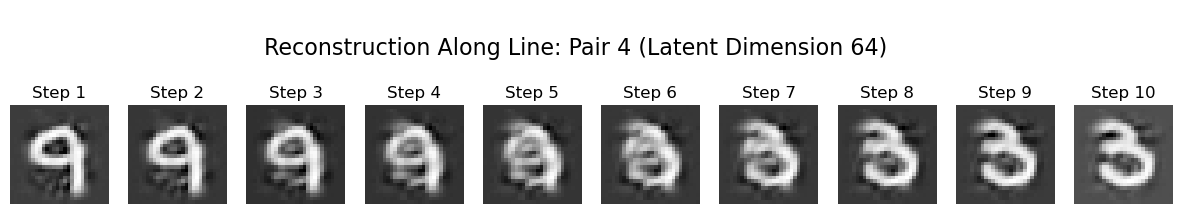

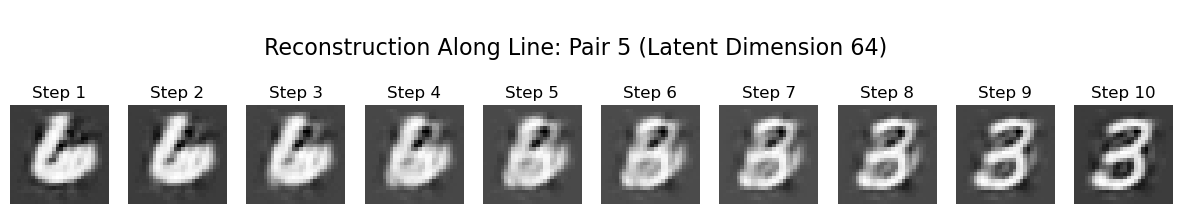

-----------------------------------------------------------------------------------------------------------


In [10]:
print('Performing reconstruction along the line in the hidden space: \n')
for model, latent_dim in zip(models, latent_dims):
    reconstruction_along_line(model, latent_dim, train_loader, num_pairs=5, num_steps=10)
    print('-'*107)

### Q2 Train a VAE for the tasks of generating MNIST-like digits.

#### VAE

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dimension):
        super(VAE, self).__init__()
        self.latent_dimension = latent_dimension

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 112),
            nn.ReLU()
        )
        self.mean = nn.Linear(112, latent_dimension)
        self.log_var = nn.Linear(112, latent_dimension)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, 112),
            nn.ReLU(),
            nn.Linear(112, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = torch.relu(self.encoder(x))
        return self.mean(x), self.log_var(x)

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = torch.relu(self.decoder(z))
        return z

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 28*28))
        z = self.reparameterization(mu, log_var)
        return self.decode(z), mu, log_var

#### Defining VAE Loss Function

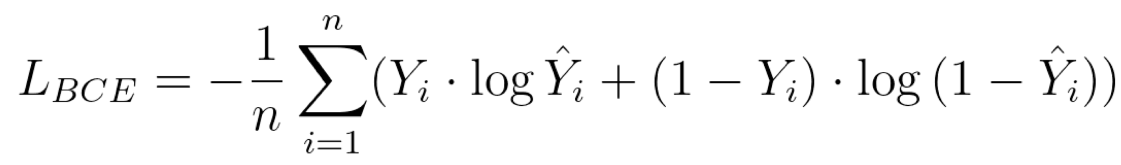

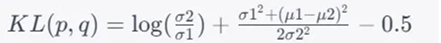

In [12]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#### Training the VAE Model

In [19]:
def train_vae(model, train_loader, optimizer, epochs=10, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for data, _ in train_loader:
            data = data.view(-1, 28*28).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        if epoch == 0:
            print("-"*65)   
        print(f"|\t Epoch {epoch+1} \t | \tAverage Loss = {train_loss / len(train_loader.dataset):.4f} \t|")
        print("-"*65)

In [20]:
latent_dim = 16
vae_model = VAE(latent_dim)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)
train_vae(vae_model, train_loader, optimizer, epochs=30)

-----------------------------------------------------------------
|	 Epoch 1 	 | 	Average Loss = 164.0673 	|
-----------------------------------------------------------------
|	 Epoch 2 	 | 	Average Loss = 123.0519 	|
-----------------------------------------------------------------
|	 Epoch 3 	 | 	Average Loss = 114.8719 	|
-----------------------------------------------------------------
|	 Epoch 4 	 | 	Average Loss = 111.3950 	|
-----------------------------------------------------------------
|	 Epoch 5 	 | 	Average Loss = 109.3750 	|
-----------------------------------------------------------------
|	 Epoch 6 	 | 	Average Loss = 108.0481 	|
-----------------------------------------------------------------
|	 Epoch 7 	 | 	Average Loss = 106.9984 	|
-----------------------------------------------------------------
|	 Epoch 8 	 | 	Average Loss = 106.1886 	|
-----------------------------------------------------------------
|	 Epoch 9 	 | 	Average Loss = 105.5337 	|
-------------------

#### Generating 64 new samples from the VAE

In [24]:
def generate_samples_vae(model, num_samples=64, latent_dim=16, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()
        return samples.view(-1, 28, 28)
    
generated_samples = generate_samples_vae(vae_model)

#### Visualizing the generated samples

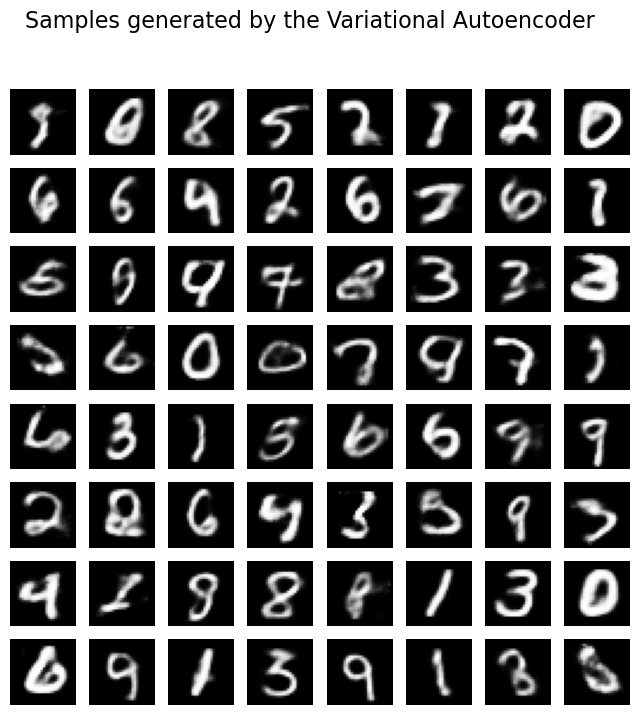

In [27]:
import matplotlib.pyplot as plt

def plot_generated_samples(samples, num_samples=64, figsize=(8, 8), title='Samples generated by the Variational Autoencoder'):
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=16)
    for i in range(num_samples):
        plt.subplot(8, 8, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and plot samples
generated_samples = generate_samples_vae(vae_model)
plot_generated_samples(generated_samples)